# ============================================================================
# CUSTOMER CHURN PREDICTION USING MACHINE LEARNING
# Bachelor's Thesis - Bank Churn Modelling Dataset
# ============================================================================


# Customer Churn Prediction Using Machine Learning

 ## 1. Introduction
 This notebook implements customer churn prediction for a banking dataset
 as part of a Bachelor's Thesis.

 ### Methodology:
 1. Data Loading & Exploration
 2. Preprocessing & Feature Engineering
 3. Model Training with Cross-Validation
 4. Hyperparameter Tuning
 5. Statistical Significance Testing
 6. Feature Importance Analysis
 7. Results & Conclusions


## 2. Import Libraries


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from scipy.stats import wilcoxon
from itertools import combinations
import warnings

warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully")


Libraries imported successfully


## 3. Data Loading


In [26]:
df = pd.read_csv('/Users/nukesaba/PyCharmMiscProject/BankChurnModelling.csv')
df = df.drop(['CustomerId', 'Surname'], axis=1)

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nTarget Distribution:")
print(df['Churn'].value_counts())
print(f"\nImbalance Ratio: {df['Churn'].value_counts()[0] / df['Churn'].value_counts()[1]:.2f}:1")


Dataset Shape: (10000, 11)

First 5 rows:
   CreditScore Geography  Gender  Age  Tenure    Balance  Num Of Products  \
0          619    France  Female   42       2       0.00                1   
1          608     Spain  Female   41       1   83807.86                1   
2          502    France  Female   42       8  159660.80                3   
3          699    France  Female   39       1       0.00                2   
4          850     Spain  Female   43       2  125510.82                1   

   Has Credit Card  Is Active Member  Estimated Salary  Churn  
0                1                 1         101348.88      1  
1                0                 1         112542.58      0  
2                1                 0         113931.57      1  
3                0                 0          93826.63      0  
4                1                 1          79084.10      0  

Target Distribution:
Churn
0    7963
1    2037
Name: count, dtype: int64

Imbalance Ratio: 3.91:1


## 4. Data Preprocessing


In [27]:
print("Missing Values:")
print(df.isnull().sum())

le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

print("\nAfter encoding:")
print(df.head())


Missing Values:
CreditScore         0
Geography           0
Gender              0
Age                 0
Tenure              0
Balance             0
Num Of Products     0
Has Credit Card     0
Is Active Member    0
Estimated Salary    0
Churn               0
dtype: int64

After encoding:
   CreditScore  Gender  Age  Tenure    Balance  Num Of Products  \
0          619       0   42       2       0.00                1   
1          608       0   41       1   83807.86                1   
2          502       0   42       8  159660.80                3   
3          699       0   39       1       0.00                2   
4          850       0   43       2  125510.82                1   

   Has Credit Card  Is Active Member  Estimated Salary  Churn  \
0                1                 1         101348.88      1   
1                0                 1         112542.58      0   
2                1                 0         113931.57      1   
3                0                 0          938

## 5. Train-Test Split & Feature Engineering


In [28]:
target = 'Churn'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 8000 samples
Test set: 2000 samples


In [29]:
# Feature Engineering - parameters computed on TRAINING data only
X_train = X_train.copy()
X_test = X_test.copy()

# BalanceToSalaryRatio
X_train['BalanceToSalaryRatio'] = X_train['Balance'] / (X_train['Estimated Salary'] + 1e-6)
X_test['BalanceToSalaryRatio'] = X_test['Balance'] / (X_test['Estimated Salary'] + 1e-6)

# ProductsPerTenure
X_train['ProductsPerTenure'] = X_train['Num Of Products'] / (X_train['Tenure'] + 1)
X_test['ProductsPerTenure'] = X_test['Num Of Products'] / (X_test['Tenure'] + 1)

# High value customer (thresholds from TRAINING data)
balance_threshold = X_train['Balance'].median()
salary_threshold = X_train['Estimated Salary'].median()

X_train['IsHighValue'] = (
        (X_train['Balance'] > balance_threshold) |
        (X_train['Estimated Salary'] > salary_threshold)
).astype(int)

X_test['IsHighValue'] = (
        (X_test['Balance'] > balance_threshold) |
        (X_test['Estimated Salary'] > salary_threshold)
).astype(int)

# Age group binning (quantiles from TRAINING data)
age_bins = [0] + X_train['Age'].quantile([0.33, 0.66]).tolist() + [100]
X_train['AgeGroup'] = pd.cut(X_train['Age'], bins=age_bins, labels=[0, 1, 2]).astype(int)
X_test['AgeGroup'] = pd.cut(X_test['Age'], bins=age_bins, labels=[0, 1, 2]).astype(int)

print(f"Final feature count: {X_train.shape[1]}")


Final feature count: 15


In [30]:
# Scaling - fit on TRAINING data only
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(f"Scaled {len(numeric_cols)} columns")


Scaled 13 columns


## 6. Model Training with Cross-Validation

SMOTE is applied INSIDE each CV fold using ImbPipeline to prevent data leakage.


In [31]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

base_models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Support Vector Machine': SVC(random_state=RANDOM_STATE),
    'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=0),
}

cv_results = {}

print("=" * 60)
print("CROSS-VALIDATION (SMOTE inside each fold)")
print("=" * 60)

for name, model in base_models.items():
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', model)
    ])

    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='f1', n_jobs=-1)

    cv_results[name] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }

    print(f"{name:25s}: F1 = {scores.mean():.4f} (+/-{scores.std():.4f})")


CROSS-VALIDATION (SMOTE inside each fold)
Logistic Regression      : F1 = 0.5010 (+/-0.0080)
Decision Tree            : F1 = 0.5028 (+/-0.0164)
k-Nearest Neighbors      : F1 = 0.5195 (+/-0.0256)
Naive Bayes              : F1 = 0.4395 (+/-0.0652)
Support Vector Machine   : F1 = 0.5836 (+/-0.0165)
XGBoost                  : F1 = 0.5870 (+/-0.0232)
LightGBM                 : F1 = 0.6056 (+/-0.0227)
CatBoost                 : F1 = 0.6148 (+/-0.0233)


In [32]:
cv_summary = pd.DataFrame({
    'Model': cv_results.keys(),
    'Mean F1': [cv_results[m]['mean'] for m in cv_results],
    'Std': [cv_results[m]['std'] for m in cv_results]
}).sort_values('Mean F1', ascending=False)

print("\n" + "=" * 60)
print("CV SUMMARY (Sorted by F1-Score)")
print("=" * 60)
print(cv_summary.to_string(index=False))



CV SUMMARY (Sorted by F1-Score)
                 Model  Mean F1      Std
              CatBoost 0.614760 0.023307
              LightGBM 0.605630 0.022741
               XGBoost 0.587027 0.023158
Support Vector Machine 0.583565 0.016534
   k-Nearest Neighbors 0.519532 0.025618
         Decision Tree 0.502765 0.016427
   Logistic Regression 0.501032 0.008033
           Naive Bayes 0.439464 0.065216


## 7. Hyperparameter Tuning

Tuning top 3 models. SMOTE is applied inside CV folds via ImbPipeline.


In [33]:
top_3_models = cv_summary.head(3)['Model'].tolist()
print(f"Top 3 models to tune: {top_3_models}")


Top 3 models to tune: ['CatBoost', 'LightGBM', 'XGBoost']


In [34]:
param_grids = {
    'LightGBM': {
        'classifier__num_leaves': [31, 50, 70],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__min_child_samples': [20, 30, 40]
    },
    'CatBoost': {
        'classifier__depth': [4, 6, 8],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__iterations': [100, 200, 300],
        'classifier__l2_leaf_reg': [1, 3, 5, 7]
    },
    'XGBoost': {
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__subsample': [0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.8, 0.9, 1.0]
    }
}

model_instances = {
    'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=0),
    'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')
}



In [35]:
def tune_model(model_name, model, param_grid, X_train, y_train, n_iter=50):
    """Hyperparameter tuning with SMOTE inside CV folds."""
    print(f"\n{'=' * 60}")
    print(f"TUNING: {model_name}")
    print(f"{'=' * 60}")

    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', model)
    ])

    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=skf,
        scoring='f1',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )

    search.fit(X_train, y_train)

    print(f"\nBest CV F1-Score: {search.best_score_:.4f}")
    print(f"Best Parameters:")
    for param, value in search.best_params_.items():
        print(f"  {param}: {value}")

    return search.best_estimator_, search.best_params_, search.best_score_



In [ ]:
tuned_models = {}
tuning_results = {}

for model_name in top_3_models:
    if model_name in param_grids:
        best_pipeline, best_params, best_score = tune_model(
            model_name,
            model_instances[model_name],
            param_grids[model_name],
            X_train, y_train
        )
        tuned_models[f"{model_name} (Tuned)"] = best_pipeline
        tuning_results[model_name] = {
            'best_params': best_params,
            'cv_score': best_score
        }




TUNING: CatBoost
Fitting 5 folds for each of 50 candidates, totalling 250 fits


## 8. Model Evaluation on Test Set


In [14]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model and return metrics."""
    y_pred = model.predict(X_test)

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

    return metrics, y_pred



In [15]:
print("=" * 60)
print("TEST SET EVALUATION")
print("=" * 60)

evaluation_results = []

for name, model in tuned_models.items():
    metrics, y_pred = evaluate_model(model, X_test, y_test, name)
    evaluation_results.append(metrics)

    print(f"\n{name}")
    print("-" * 40)
    print(f"Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall:    {metrics['Recall']:.4f}")
    print(f"F1-Score:  {metrics['F1-Score']:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


TEST SET EVALUATION

CatBoost (Tuned)
----------------------------------------
Accuracy:  0.8570
Precision: 0.6744
Recall:    0.5749
F1-Score:  0.6207

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1593
           1       0.67      0.57      0.62       407

    accuracy                           0.86      2000
   macro avg       0.78      0.75      0.77      2000
weighted avg       0.85      0.86      0.85      2000

Confusion Matrix:
[[1480  113]
 [ 173  234]]

LightGBM (Tuned)
----------------------------------------
Accuracy:  0.8540
Precision: 0.6657
Recall:    0.5676
F1-Score:  0.6127

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1593
           1       0.67      0.57      0.61       407

    accuracy                           0.85      2000
   macro avg       0.78      0.75      0.76      2000
weighted avg       0.85   

In [16]:
results_df = pd.DataFrame(evaluation_results).sort_values('F1-Score', ascending=False)

print("\n" + "=" * 60)
print("RESULTS SUMMARY")
print("=" * 60)
print(results_df.to_string(index=False))

best_model_name = results_df.iloc[0]['Model']
best_f1 = results_df.iloc[0]['F1-Score']
print(f"\nBest Model: {best_model_name} with F1-Score = {best_f1:.4f}")



RESULTS SUMMARY
           Model  Accuracy  Precision   Recall  F1-Score
 XGBoost (Tuned)    0.8545   0.650259 0.616708  0.633039
CatBoost (Tuned)    0.8570   0.674352 0.574939  0.620690
LightGBM (Tuned)    0.8540   0.665706 0.567568  0.612732

Best Model: XGBoost (Tuned) with F1-Score = 0.6330


## 9. Statistical Significance Testing

Wilcoxon signed-rank test to compare models.


In [17]:
print("Collecting CV scores for statistical testing...")

cv_scores_dict = {}
for name, model in tuned_models.items():
    # Use same pipeline approach for fair comparison
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1', n_jobs=-1)
    cv_scores_dict[name] = scores
    print(f"{name:25s}: {scores.mean():.4f} (+/-{scores.std():.4f})")



CatBoost (Tuned)         : 0.6263 (+/-0.0228)
LightGBM (Tuned)         : 0.6109 (+/-0.0189)
XGBoost (Tuned)          : 0.6186 (+/-0.0215)


In [18]:
def wilcoxon_test(scores_a, scores_b, name_a, name_b):
    """Wilcoxon signed-rank test between two models."""
    statistic, p_value = wilcoxon(scores_a, scores_b)

    diff = scores_a - scores_b
    cohens_d = np.mean(diff) / np.std(diff, ddof=1) if np.std(diff, ddof=1) > 0 else 0

    return {
        'Model A': name_a,
        'Model B': name_b,
        'Mean A': np.mean(scores_a),
        'Mean B': np.mean(scores_b),
        'p-value': p_value,
        "Cohen's d": cohens_d,
        'Significant': p_value < 0.05
    }



In [19]:
print("\n" + "=" * 60)
print("STATISTICAL SIGNIFICANCE TESTING")
print("=" * 60)

model_names = list(cv_scores_dict.keys())
comparisons = list(combinations(model_names, 2))

alpha = 0.05
corrected_alpha = alpha / len(comparisons)
print(f"Comparisons: {len(comparisons)}")
print(f"Bonferroni-corrected alpha: {corrected_alpha:.6f}")

significance_results = []
for name_a, name_b in comparisons:
    result = wilcoxon_test(
        cv_scores_dict[name_a],
        cv_scores_dict[name_b],
        name_a, name_b
    )
    result['Significant (Bonferroni)'] = result['p-value'] < corrected_alpha
    significance_results.append(result)

significance_df = pd.DataFrame(significance_results)
print("\n" + significance_df.to_string(index=False))

n_significant = significance_df['Significant'].sum()
n_bonferroni = significance_df['Significant (Bonferroni)'].sum()

print(f"\nSignificant at alpha=0.05: {n_significant}/{len(comparisons)}")
print(f"Significant with Bonferroni: {n_bonferroni}/{len(comparisons)}")




STATISTICAL SIGNIFICANCE TESTING
Comparisons: 3
Bonferroni-corrected alpha: 0.016667

         Model A          Model B   Mean A   Mean B  p-value  Cohen's d  Significant  Significant (Bonferroni)
CatBoost (Tuned) LightGBM (Tuned) 0.626309 0.610946   0.0625   1.843247        False                     False
CatBoost (Tuned)  XGBoost (Tuned) 0.626309 0.618610   0.3125   0.600481        False                     False
LightGBM (Tuned)  XGBoost (Tuned) 0.610946 0.618610   0.1875  -0.670485        False                     False

Significant at alpha=0.05: 0/3
Significant with Bonferroni: 0/3


## 10. Feature Importance Analysis


In [20]:
def get_feature_importance(model, feature_names, model_name):
    """Extract feature importance from model."""
    # For pipeline, get the classifier step
    if hasattr(model, 'named_steps'):
        classifier = model.named_steps['classifier']
    else:
        classifier = model

    if hasattr(classifier, 'feature_importances_'):
        importance = classifier.feature_importances_
        return pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values('Importance', ascending=False)
    else:
        print(f"{model_name} does not have feature_importances_")
        return None



In [21]:
feature_names = X_train.columns.tolist()

print("=" * 60)
print("FEATURE IMPORTANCE")
print("=" * 60)

for name, model in tuned_models.items():
    importance_df = get_feature_importance(model, feature_names, name)
    if importance_df is not None:
        print(f"\n{name} - Top 10 Features:")
        print(importance_df.head(10).to_string(index=False))


FEATURE IMPORTANCE

CatBoost (Tuned) - Top 10 Features:
          Feature  Importance
           Tenure   34.609370
ProductsPerTenure   13.654230
  Num Of Products   12.896271
              Age   12.063636
         AgeGroup    9.345535
Geography_Germany    4.244132
 Is Active Member    3.124219
          Balance    2.361974
           Gender    1.695728
  Geography_Spain    1.595581

LightGBM (Tuned) - Top 10 Features:
             Feature  Importance
                 Age        1060
   ProductsPerTenure         647
              Tenure         645
             Balance         622
         CreditScore         608
    Estimated Salary         607
     Num Of Products         441
BalanceToSalaryRatio         401
            AgeGroup         211
    Is Active Member         205

XGBoost (Tuned) - Top 10 Features:
          Feature  Importance
         AgeGroup    0.233145
  Num Of Products    0.156547
Geography_Germany    0.153416
 Is Active Member    0.099820
              Age    0.08761

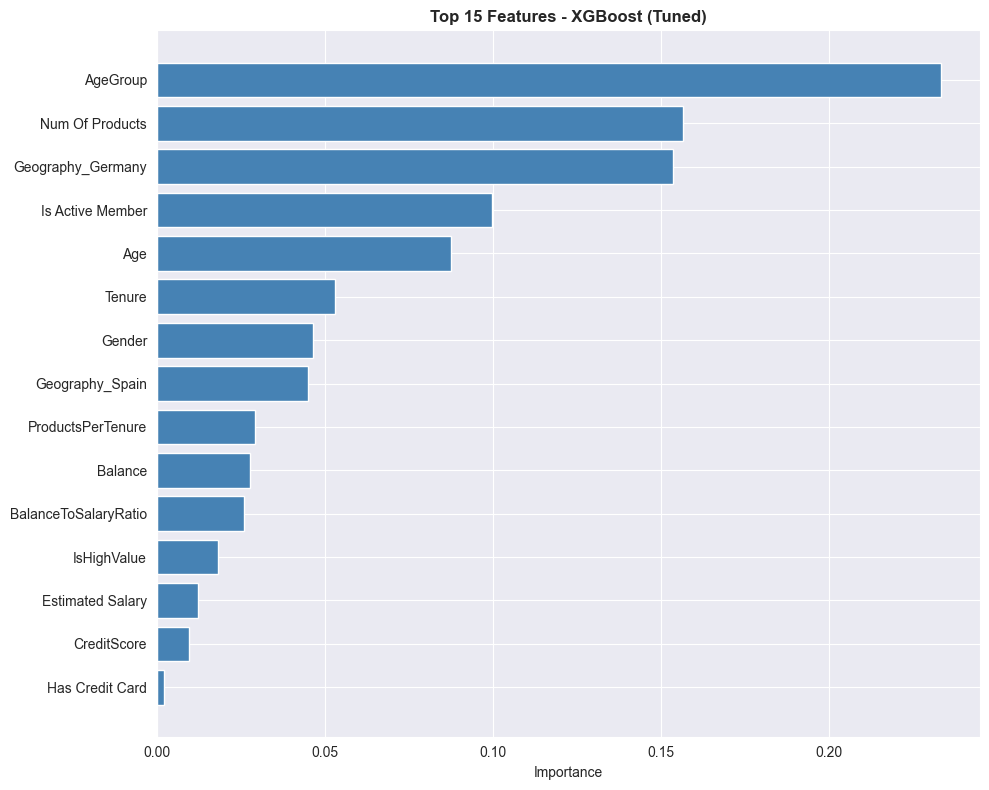

In [22]:
best_model = tuned_models[best_model_name]
importance_df = get_feature_importance(best_model, feature_names, best_model_name)

if importance_df is not None:
    plt.figure(figsize=(10, 8))
    top_15 = importance_df.head(15)

    plt.barh(range(len(top_15)), top_15['Importance'], color='steelblue')
    plt.yticks(range(len(top_15)), top_15['Feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 15 Features - {best_model_name}', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('BankChurn1/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()


## 11. Confusion Matrix Visualization


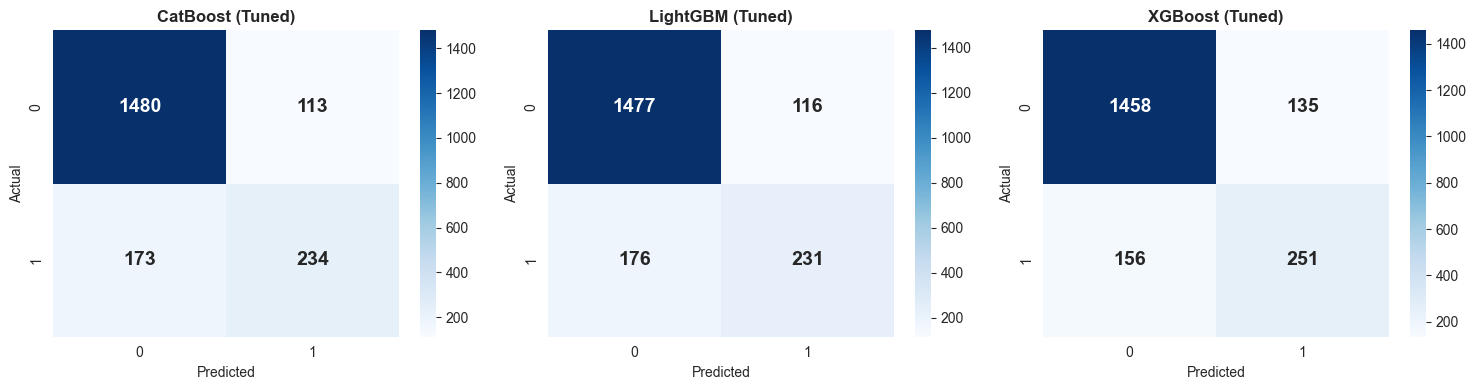

In [23]:
fig, axes = plt.subplots(1, len(tuned_models), figsize=(5 * len(tuned_models), 4))
if len(tuned_models) == 1:
    axes = [axes]

for idx, (name, model) in enumerate(tuned_models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                annot_kws={'fontsize': 14, 'fontweight': 'bold'})
    axes[idx].set_title(f'{name}', fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('BankChurn1/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


## 12. Conclusions


In [24]:
print("=" * 70)
print("FINAL SUMMARY")
print("=" * 70)

print("\n1. BEST MODEL:")
print(f"   {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")

print("\n2. ALL MODELS:")
print(results_df.to_string(index=False))

print("\n3. STATISTICAL SIGNIFICANCE:")
if n_bonferroni > 0:
    print(f"   {n_bonferroni} significant difference(s) found")
else:
    print("   No significant differences - models perform comparably")

print("\n4. TOP 5 FEATURES:")
if importance_df is not None:
    for idx, row in importance_df.head(5).iterrows():
        print(f"   {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "=" * 70)

FINAL SUMMARY

1. BEST MODEL:
   XGBoost (Tuned)
   F1-Score: 0.6330
   Accuracy: 0.8545

2. ALL MODELS:
           Model  Accuracy  Precision   Recall  F1-Score
 XGBoost (Tuned)    0.8545   0.650259 0.616708  0.633039
CatBoost (Tuned)    0.8570   0.674352 0.574939  0.620690
LightGBM (Tuned)    0.8540   0.665706 0.567568  0.612732

3. STATISTICAL SIGNIFICANCE:
   No significant differences - models perform comparably

4. TOP 5 FEATURES:
   AgeGroup: 0.2331
   Num Of Products: 0.1565
   Geography_Germany: 0.1534
   Is Active Member: 0.0998
   Age: 0.0876

